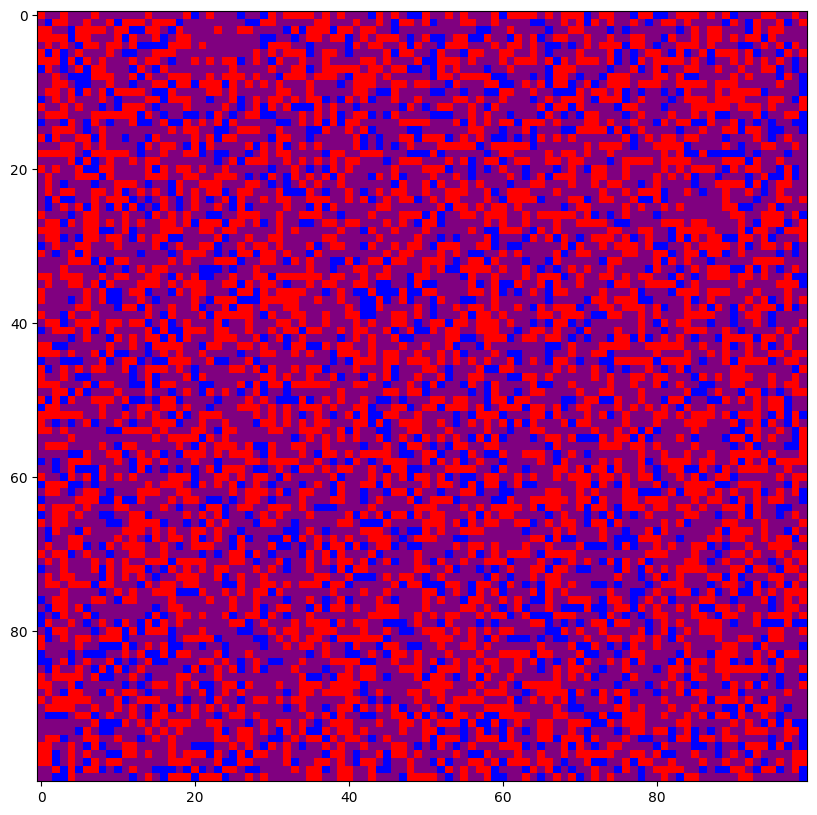

In [2]:
from main import LearningModel

#Here you can run a model once with different learning models and food environments. 
#You can either use 'TD', 'RW', or 'RWE' at learning_model.
#You can pick 'random', 'gradient_l', 'gradient_h', 'weekday' as food environments.
#You can also fill in an integer (e.g., 1) after seed to make the simulation reproducible.
#Epsilon represents the probability that an agent chooses the other option regardless of preference. For example, when dieting.

m = LearningModel(N=100, width=100, height=100, learning_model='RW', distribute_patches = 'random', seed = None, epsilon = 0.05)

for i in range(100):
    m.step()

df = m.datacollector.get_agent_vars_dataframe()
df1 = df.reset_index()

m.visualize() #In case you want to check distribution of food on map.

Text(0, 0.5, 'V')

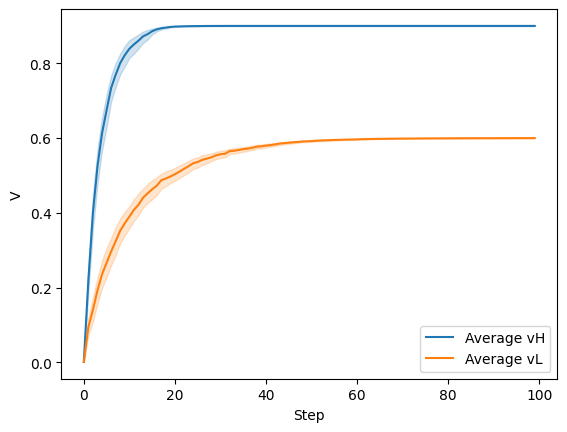

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot the results of the single run. #ADAPT COLORS BASED ON RED AND BLUE IN GRAPH.

sns.lineplot(df1, x = "Step", y = "Value_High", label = "Average vH")
sns.lineplot(df1, x = "Step", y = "Value_Low", label = "Average vL")
plt.ylabel('V')

In [4]:
from main import LearningModel
from tqdm import tqdm 
import pandas as pd

#With the batch_run function you can run the model in 6 different configurations as often as you like. This will return a dataframe called "data".
#The dataframe contains time-series data for all agents for every single run in the 6 different configurations.

iterations = 10
learning_models = ["RW", "TD", "RWE"]
distribute_patches = ["random", "gradient_h", "gradient_l", "weekday"]
epsilon = [0.05, 0.25, 0.50, 0.75, 0.9]

def batch_run():
    all_data = []
    
    total_runs = len(learning_models) * len(distribute_patches) * iterations
    progress_bar = tqdm(total=total_runs, desc="Batch Running")

    for learning_model in learning_models:
        for distribute_patch in distribute_patches:
            batch_run_data = []
            for i in range(iterations):
                model = LearningModel(N=100, width=100, height=100, learning_model=learning_model, distribute_patches=distribute_patch)
                
                # Run the model for a fixed number of steps
                for _ in range(100):
                    model.step()
                
                # Get model data
                m_data = model.datacollector.get_agent_vars_dataframe()
                m_data['Run'] = i
                m_data['Learning_Model'] = learning_model
                m_data['Distribute_Patches'] = distribute_patch
                batch_run_data.append(m_data)

                progress_bar.update(1)
            
            # Concatenate the data for this configuration
            batch_run_data = pd.concat(batch_run_data)
            all_data.append(batch_run_data)
    
    # Concatenate all configurations
    all_data = pd.concat(all_data)
    
    return all_data

# Run the custom batch run function
data = batch_run()

Batch Running: 100%|██████████| 120/120 [00:15<00:00,  7.70it/s]


In [24]:
data = data.reset_index()

#### Initial model comparison in random environment

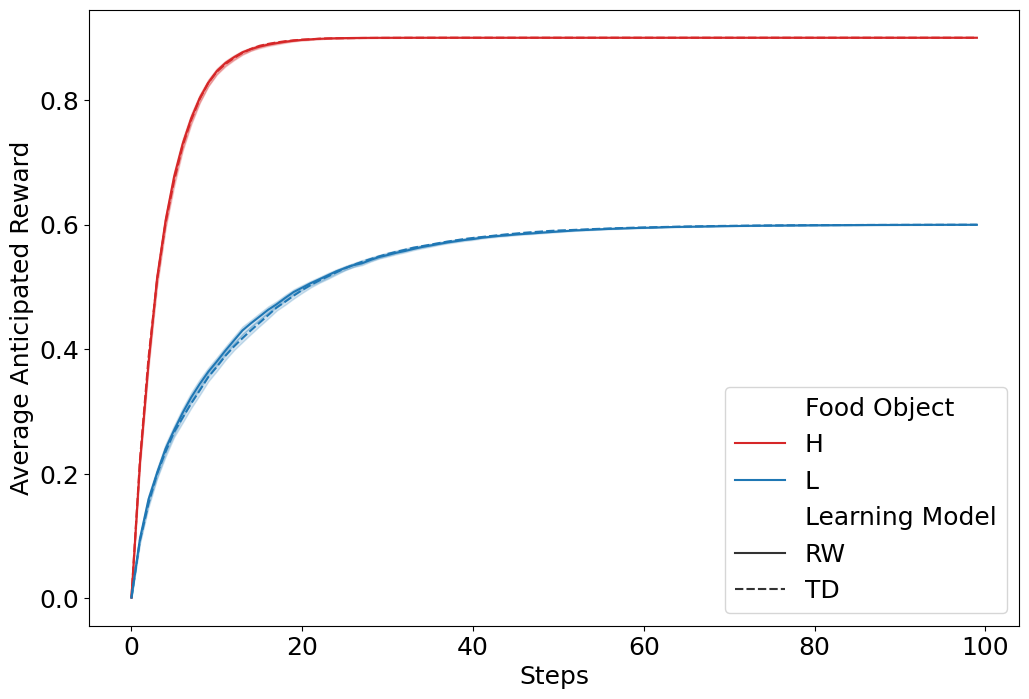

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_random_env_rw_td(data, legend_labels, custom_palette):
    # Filter data for the 'random' environment and 'RW' and 'TD' learning models
    df_filtered = data[(data['Distribute_Patches'] == 'random') & 
                       (data['Learning_Model'].isin(['RW', 'TD']))]

    # Melt the DataFrame to long format for easier plotting with seaborn
    df_melted = df_filtered.melt(id_vars=['Step', 'Learning_Model'], 
                                 value_vars=['Value_High', 'Value_Low'], 
                                 var_name='Food', value_name='Value')

    plt.rcParams.update({
        'font.size': 18,          # general font size
        'axes.titlesize': 20,     # title font size
        'axes.labelsize': 18,     # x and y label font size
        'xtick.labelsize': 18,    # x tick label font size
        'ytick.labelsize': 18,    # y tick label font size
        'legend.fontsize': 18     # legend font size
    })

    # Plot the data using seaborn
    plt.figure(figsize=(12, 8))
    
    sns.lineplot(data=df_melted, x='Step', y='Value', hue='Food', 
                 style='Learning_Model', estimator='mean', errorbar=('ci', 80), palette= custom_palette)
    
    plt.xlabel('Steps')
    plt.ylabel('Average Anticipated Reward')

    # Customizing the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [legend_labels.get(label, label) for label in labels]
    plt.legend(handles, new_labels, title='')

    plt.show()

# Example of how to use the function with custom legend labels
legend_labels = {
    'Value_High': 'H',
    'Value_Low': 'L',
    'Learning_Model': 'Learning Model',
    'Food': 'Food Object'
}

custom_palette = {
    'Value_High': '#d62728',
    'Value_Low': '#1f77b4'

}

# Assuming 'data' is the DataFrame with your results
plot_random_env_rw_td(data, legend_labels, custom_palette)


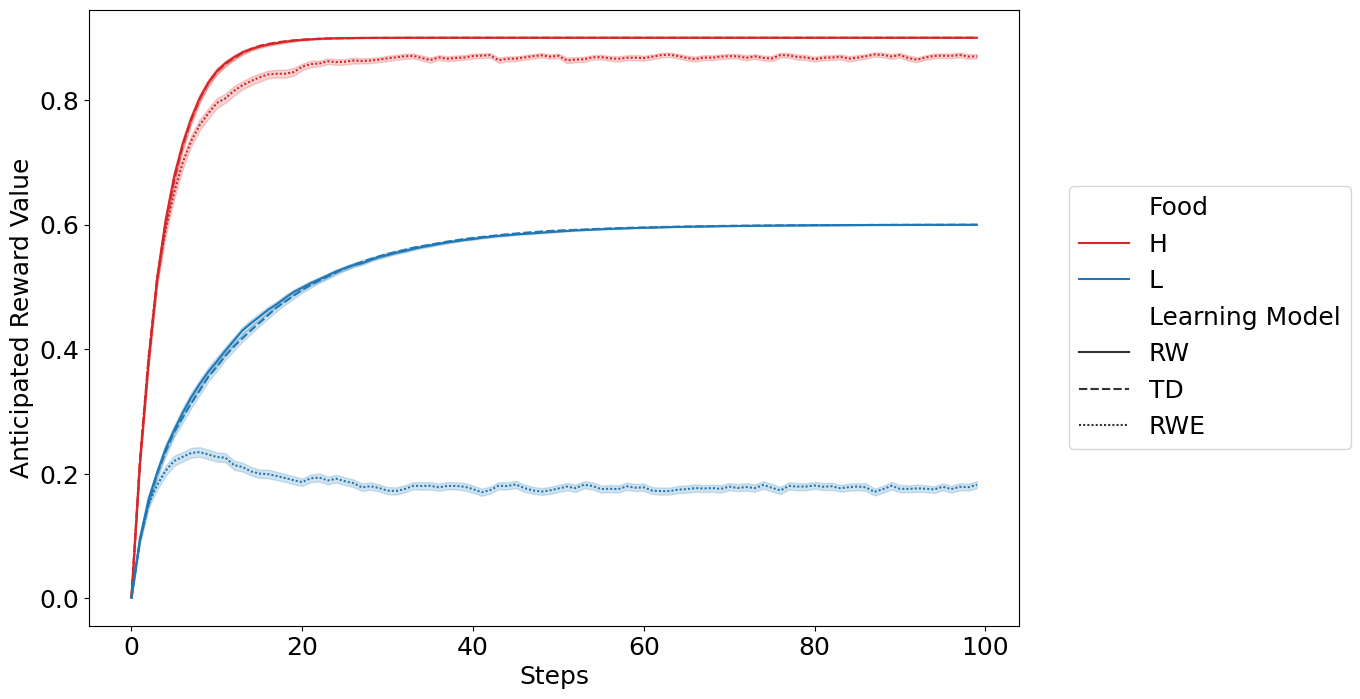

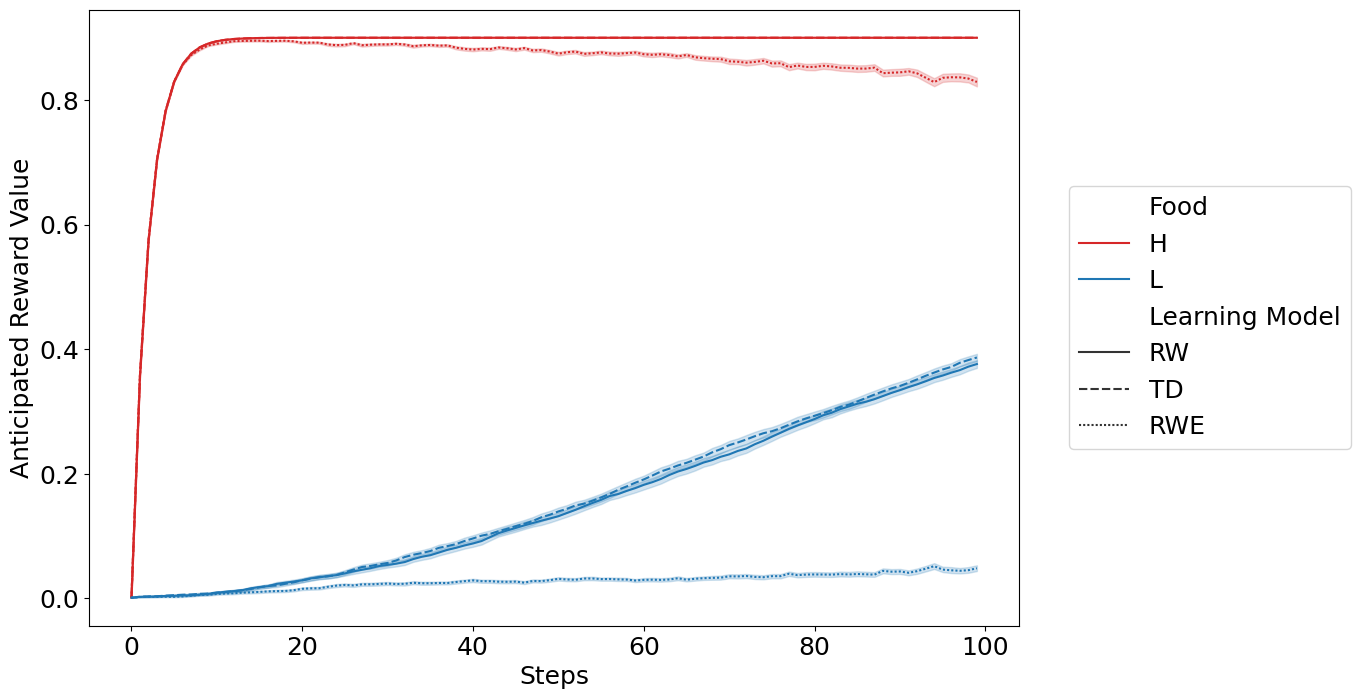

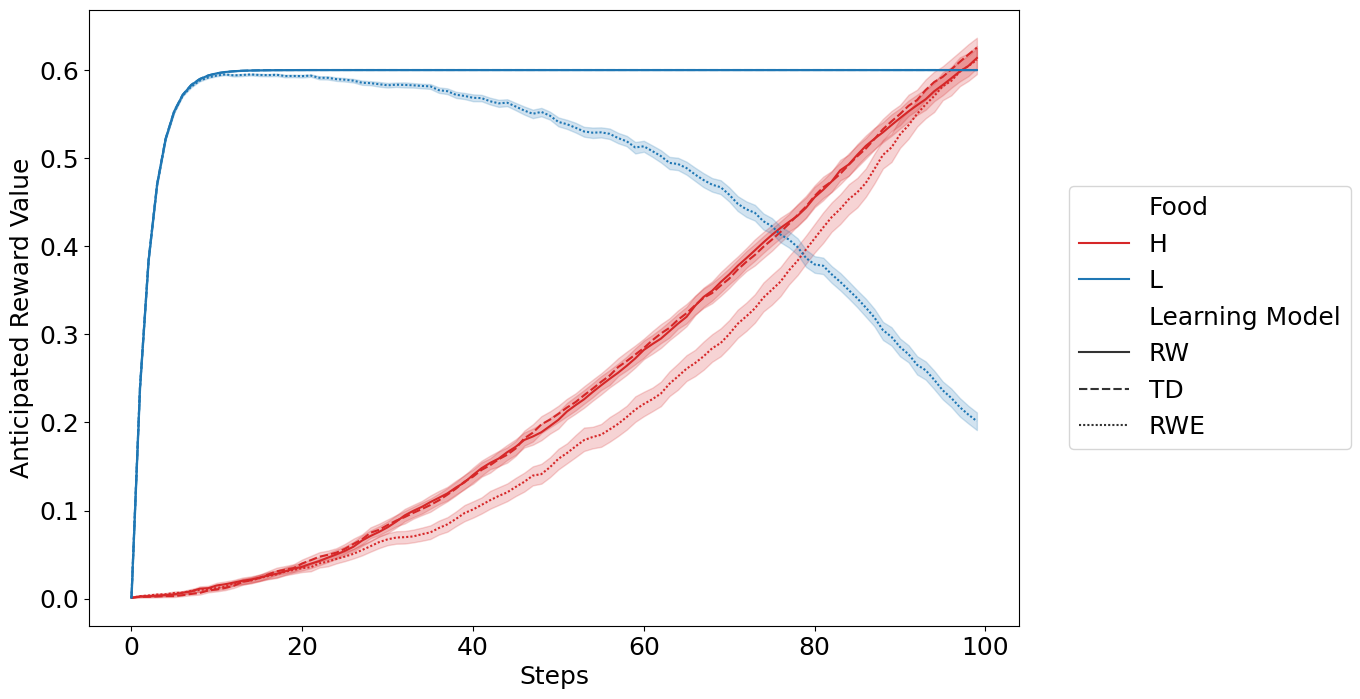

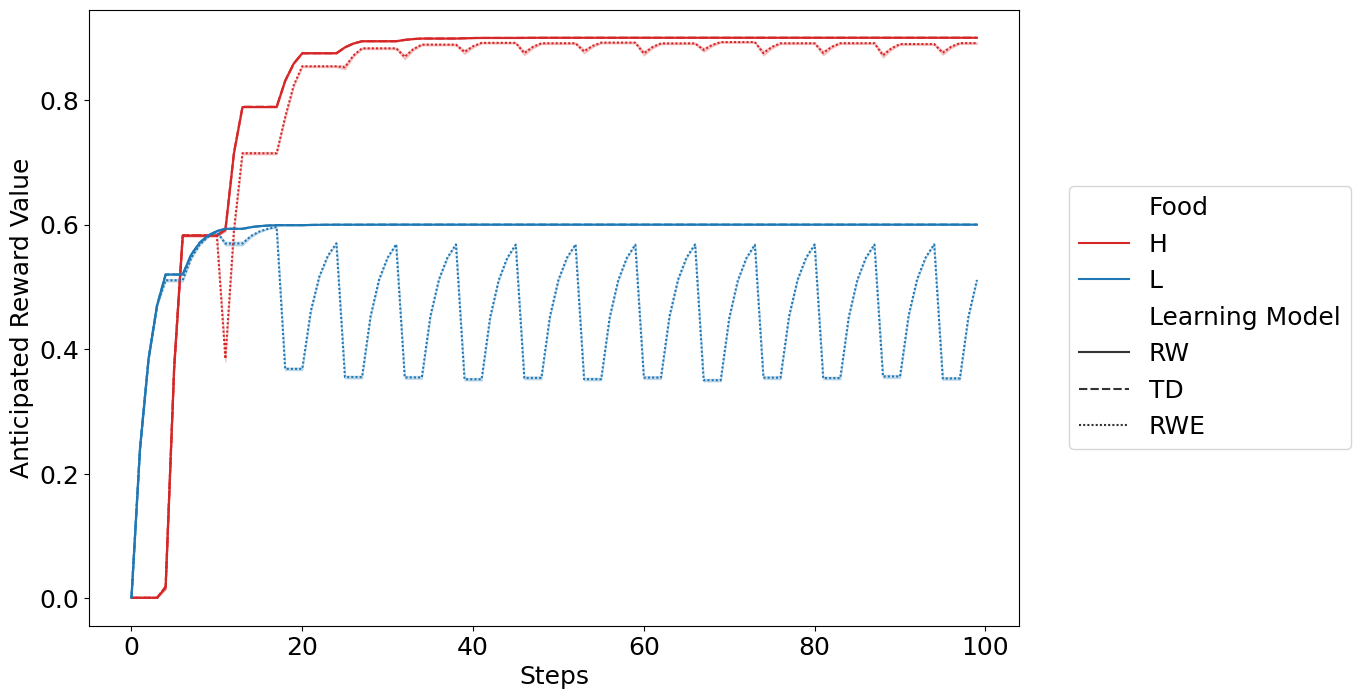

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(data, distribute_patch, legend_labels, custom_palette):
    # Filter data for the specific distribute_patch
    df_filtered = data[data['Distribute_Patches'] == distribute_patch]
    
    df_melted = df_filtered.melt(id_vars=['Step', 'Learning_Model'], 
                                 value_vars=['Value_High', 'Value_Low'], 
                                 var_name='Food', value_name='Value')

    # Plot the data using seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_melted, x='Step', y='Value', hue = 'Food', style='Learning_Model', palette = custom_palette, estimator='mean', errorbar=('ci', 80))
    plt.xlabel('Steps')
    plt.ylabel('Anticipated Reward Value')
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [legend_labels.get(label, label) for label in labels]
    plt.legend(handles, new_labels, title='', bbox_to_anchor=(1.04, 0.5), loc = "center left")

    plt.show()

# Example of how to use the function with custom legend labels
legend_labels = {
    'Value_High': 'H',
    'Value_Low': 'L',
    'Learning_Model': 'Learning Model'
}

custom_palette = {
    'Value_High': '#d62728',
    'Value_Low': '#1f77b4'

}

# Plot results for each distribute_patch
for distribute_patch in distribute_patches:
    plot_results(data, distribute_patch, legend_labels, custom_palette)